# XGBoost
* [Carga de los datos](#carga-de-los-datos)
* [Modelo Baseline](#modelo-baseline)
* [Transformaciones](#transformaciones)
* [Selección de variables](#selección-de-variables)
* [Ajuste de hiperparámetros](#ajuste-de-hiperparámetros)
* [Conclusiones](#conclusiones)

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import  GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,log_loss, make_scorer, f1_score, roc_auc_score, precision_score, recall_score, balanced_accuracy_score
import os
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import mlflow

### Descripción general del notebook

En este notebook realizaremos el modelado y entrenamiento de un modelo XGBoost para predecir el ganador de una pelea utilizando datos previos. Para ello, emplearemos un dataframe con medias ponderadas de combates anteriores y variables como la racha de victorias con la que llega el luchador a la pelea, un sistema de puntos diseñado manualmente, entre otros factores.

En la fase de entrenamiento, buscaremos los hiperparámetros óptimos utilizando dos estrategias de ajuste. Para evaluar si el ajuste de hiperparámetros ha tenido un impacto positivo, primero crearemos un modelo base (baseline), a partir del cual extraeremos conclusiones iniciales y posteriormente intentaremos mejorarlo.

Para el ajuste de hiperparámetros, utilizaremos las técnicas de búsqueda en rejilla (grid search) y búsqueda aleatoria (random search). En ambos casos, seleccionaremos el modelo con el mejor F1-score utilizando validación cruzada, ya que, aunque buscamos maximizar la accuracy, queremos evitar que el modelo se enfoque únicamente en la clase mayoritaria y deje de predecir la clase minoritaria.

El objetivo principal del notebook es desarrollar un modelo con un buen desempeño que pueda ser utilizado en la fase de despliegue.

In [35]:
ruta_mlflow = os.path.abspath(os.path.join("..", "..", "..", "mlruns"))

# Configurar MLflow para guardar los modelos en esa ruta
mlflow.set_tracking_uri(f"file:///{ruta_mlflow}")

print("MLflow tracking URI:", mlflow.get_tracking_uri())  

MLflow tracking URI: file:///c:\Users\mattu\OneDrive\Documentos\GitHub\c2425-R4\mlruns


In [60]:
mlflow.set_experiment("Prueba con df ponderado P2 usando P2_dif XGBoost, datos finales")

<Experiment: artifact_location='file:///c:\\Users\\mattu\\OneDrive\\Documentos\\GitHub\\c2425-R4\\mlruns/327375263980051994', creation_time=1742983623731, experiment_id='327375263980051994', last_update_time=1742986278423, lifecycle_stage='active', name='Prueba con df ponderado P2 usando P2_dif XGBoost, datos finales', tags={}>

Para guardar los resultados de diferentes experimentos creamos un directorio mlruns donde se guardarán los modelos realizados con una breve descripción y sus resultados.

#### CARGA DE LOS DATOS

Cargamos el conjunto de train y test los cuales han sido seleccionados respetando el orden cronológico debido a que es una serie temporal. Separamos los conjuntos en X e y. En X guardamos todas las variables que puedan ser introducidas al modelo, excluyendo los nombres, la fecha y la variable respuesta. En y guardamos la variable respuesta.

In [36]:
#Leo los df divididos en orden cronológico de forma que los resultados sean lo más reales posibles
ruta_train =  os.path.join("..","..","..", "data", "P2","train.parquet")
df_train = pd.read_parquet(ruta_train)
df_train.head()

,DATE,Peleador_A,Peleador_B,WINNER,KD_A,KD_B,SIG_STR_A,SIG_STR_B,TD_PORC_A,TD_PORC_B,...,Puntos_A,Puntos_B,Peleas_A,Peleas_B,KD_DIFF,SIG_STR_DIFF,TD_DIFF,SUB_ATT_DIFF,REV_DIFF,CTRL_DIFF
0,2010-01-02,Rashad Evans,Thiago Silva,False,0.40,0.36,0.3184,0.5992,0.2400,0.000,...,5.148266,13.544990,10,6,0.04,-0.2808,0.193548,-0.40,0.00,-18.84
1,2010-01-02,Sam Stout,Joe Lauzon,False,0.36,0.00,0.2724,0.4952,0.2400,0.744,...,0.000003,8.453161,7,6,0.36,-0.2228,-0.371306,-2.72,0.00,-101.68
2,2010-01-11,Rafael Dos Anjos,Kyle Bradley,False,0.00,0.00,0.3572,0.3156,0.3216,0.360,...,0.000011,10.000000,3,3,0.00,0.0416,0.086912,1.52,0.24,213.96
3,2010-01-11,Amir Sadollah,Brad Blackburn,False,0.00,1.84,0.4288,0.4464,0.0000,0.000,...,10.000000,11.547747,3,3,-1.84,-0.0176,0.000000,0.44,0.00,23.04
4,2010-01-11,Gray Maynard,Nate Diaz,False,0.00,0.00,0.3420,0.2928,0.6752,0.480,...,9.655488,12.609416,7,8,0.00,0.0492,0.328320,-0.52,-0.48,249.72


In [37]:
ruta_test = os.path.join("..","..","..","data", "P2","test.parquet")
df_test = pd.read_parquet(ruta_test)
df_test.head()

,DATE,Peleador_A,Peleador_B,WINNER,KD_A,KD_B,SIG_STR_A,SIG_STR_B,TD_PORC_A,TD_PORC_B,...,Puntos_A,Puntos_B,Peleas_A,Peleas_B,KD_DIFF,SIG_STR_DIFF,TD_DIFF,SUB_ATT_DIFF,REV_DIFF,CTRL_DIFF
0,2022-11-19,Kennedy Nzechukwu,Ion Cutelaba,False,0.00,0.40,0.4176,0.5208,0.2556,0.8640,...,86.483419,0.000000,7,13,-0.4,-0.1032,-0.110729,0.36,0.00,-39.60
1,2022-11-19,Vince Morales,Miles Johns,True,0.24,0.64,0.4028,0.4848,0.1000,0.0000,...,69.390238,54.933053,7,5,-0.4,-0.0820,0.153846,0.00,0.36,-52.16
2,2022-11-19,Andre Fialho,Muslim Salikhov,True,0.64,0.24,0.5220,0.4524,0.0000,0.2484,...,64.524204,127.265131,4,7,0.4,0.0696,-0.192661,0.00,0.00,-54.80
3,2022-11-19,Jennifer Maia,Maryna Moroz,False,0.00,0.00,0.3240,0.4880,0.0900,0.2480,...,15.229011,37.550440,9,9,0.0,-0.1640,-0.069020,-1.08,0.00,-340.04
4,2022-12-03,Eryk Anders,Kyle Daukaus,False,0.00,0.00,0.4532,0.5928,0.0432,0.2000,...,0.000000,58.874428,14,6,0.0,-0.1396,-0.158176,-1.68,0.40,189.72


In [38]:
X_train = df_train.drop(columns=["DATE","Peleador_A","Peleador_B","WINNER"])
y_train = df_train["WINNER"]
y_train.value_counts(normalize=True)

WINNER
False    0.56343
True     0.43657
Name: proportion, dtype: float64

In [40]:
X_test = df_test.drop(columns=["DATE","Peleador_A","Peleador_B","WINNER"])
y_test = df_test["WINNER"]
y_test.value_counts(normalize=True)

WINNER
False    0.546166
True     0.453834
Name: proportion, dtype: float64

Como podemos ver hay una ligera desigualdad en la distribución de la variable respuesta, esto se debe a que el peleador A suele ser el favorito o el que se situa más arriba en el ranking.

#### MODELO BASELINE

Creo un modelo simple el cual debería conseguir mejorar tras realizar los ajustes de hiperparámetros. Para este modelo usaré los hiperparámetros por defecto de XGBoost, sin tener en cuenta los ligeros desbalances de clase ni eliminando atributos no útiles.

In [41]:
base = XGBClassifier(random_state=42)
base.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [42]:
print("-- Métricas del modelo con hiperparámetros ajustados --")
y_val_pred = base.predict(X_test)
y_val_prob = base.predict_proba(X_test)[:,1]
print("Accuracy:", accuracy_score(y_test, y_val_pred))
f1_val = f1_score(y_test, y_val_pred)
roc_auc_val = roc_auc_score(y_test, y_val_prob)
precision_val = precision_score(y_test, y_val_pred)
recall_val = recall_score(y_test, y_val_pred)
log_loss_val = log_loss(y_test,y_val_prob)
print(f"F1-Score: {f1_val:.4f}")
print(f"AUC-ROC: {roc_auc_val:.4f}")
print(f"Precisión: {precision_val:.4f}")
print(f"Sensibilidad: {recall_val:.4f}")
print(f"Log-loss: {log_loss_val}")

-- Métricas del modelo con hiperparámetros ajustados --
Accuracy: 0.5258215962441315
F1-Score: 0.4618
AUC-ROC: 0.5332
Precisión: 0.4762
Sensibilidad: 0.4483
Log-loss: 0.9296362005270357


El accuracy obtenido está algo por debajo al que se obtendría prediciendo siempre al favorito. Tras realizar el ajuste de hiperparámetros esperamos conseguir al menos un accuracy superior al anteriormente mencionado.

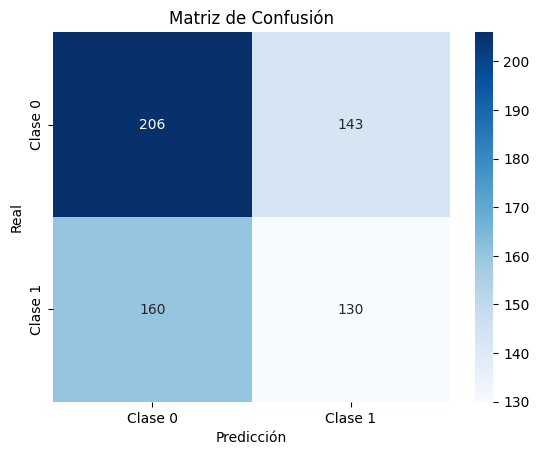

In [43]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_val_pred)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

En la matriz de confusión podemos ver que el modelo no obtiene malos resultados cuando gana el favorito. En cambio podemos ver que hay una gran tasa de error cuando gana el no favorito o "underdog". Este desequilibrio es uno de los objetivos a paliar al realizar el ajuste de hiperparámetros.

### TRANSFORMACIONES

Para el modelo XGBoost no es necesario realizar transformaciones previas de las variables, como la normalización o estandarización, ya que al ser un modelo basado en árboles de decisión, no se ve afectado por las diferencias en las escalas de los valores ni por la falta de normalidad en la distribución de las variables. Los árboles utilizan divisiones basadas en umbrales y no dependen de operaciones algebraicas sensibles a las magnitudes de las variables.

### SELECCIÓN DE VARIABLES

El modelo XGBoostClassifier no requiere una selección explícita de variables antes del entrenamiento. Al ser un modelo de ensamble de árboles, cada nodo selecciona automáticamente la variable que proporciona la mayor ganancia de información o reducción de impureza. Las variables irrelevantes tienden a ser ignoradas durante las divisiones, por lo que no contribuyen significativamente al modelo final ni añaden ruido. Además, XGBoost incluye regularización, lo que ayuda a reducir aún más el impacto de características poco informativas.


### AJUSTE DE HIPERPARÁMETROS

Para buscar una configuración óptima de hiperparámetros en este caso he utilizado tres estrategias, **GridSearchCV**, **RandomizedSearchCV** y **Optuna**. 

Para usar **GridSearchCV** he definido una cuadrícula (diccionario) con cada hiperparámetro y los posibles valores que pueden tomar. **GridSearchCV** realiza una búsqueda exhaustiva probando todas las combinaciones posibles de hiperparámetros, evaluando cada modelo mediante validación cruzada. El objetivo es encontrar la combinación que maximice el rendimiento del modelo según el F1-score. Una vez identificado el mejor conjunto de hiperparámetros, procederemos a estudiar el comportamiento del modelo óptimo.

A diferencia de **GridSearchCV**, **RandomizedSearchCV** también explora combinaciones de hiperparámetros, pero en lugar de probar todas las combinaciones posibles, selecciona un número fijo de combinaciones al azar. Esto permite explorar un espacio más amplio de hiperparámetros con un menor costo computacional. Al igual que en la búsqueda exhaustiva, las combinaciones son evaluadas mediante validación cruzada, y se selecciona el modelo que optimiza el F1-score.

Por último, he utilizado **Optuna**, un método de optimización más avanzado y menos conocido. Optuna realiza una búsqueda eficiente de hiperparámetros mediante un enfoque basado en optimización bayesiana. En lugar de probar combinaciones de manera aleatoria o exhaustiva, este método ajusta dinámicamente los valores de los hiperparámetros en función de los resultados obtenidos en pruebas anteriores (trials). Esto permite explorar de manera más inteligente el espacio de búsqueda, centrándose en las regiones más prometedoras y mejorando la eficiencia en comparación con **GridSearchCV** y **RandomizedSearchCV**.

Como podemos ver en nuestro modelo baseline hay problemas notables respecto a las predicciones de la Clase-1, intentaremos conseguir un mejor modelo usando las técnicas de ajuste de hiperparámetros

In [44]:
def train_xgboost_grid(X_train, y_train, X_val, y_val):
    # Calcular pesos de clase para manejar desbalance de datos
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    scale_pos_weight = class_weights[1] / class_weights[0] if len(class_weights) > 1 else 1
    tscv = TimeSeriesSplit(n_splits=5)
    # Definir modelo base
    xgb = XGBClassifier(random_state=42)


    param_grid = {
    'n_estimators': [100, 250],
    'learning_rate': [0.01, 0.05],  
    'subsample': [0.7, 1.0],  
    'colsample_bytree': [0.5, 0.7, 1.0],  # Añadir 0.5 para más regularización
    'gamma': [0, 0.1],  
    'min_child_weight': [10,35,50],  # Añadir 3 como punto intermedio 
    'reg_alpha': [0.1, 1.0], 
    'reg_lambda': [0.1, 1.0], 
    'scale_pos_weight': [1, scale_pos_weight]  
}


    # Definir la métrica de optimización como el F1-score macro
    f1_scorer = make_scorer(f1_score, average='macro')

    # Búsqueda con validación cruzada
    grid_search = GridSearchCV(
        estimator=xgb,
        param_grid=param_grid,
        scoring=f1_scorer,
        cv=tscv,
        n_jobs=-1,
        verbose=2
    )

    # Entrenar el modelo
    grid_search.fit(X_train, y_train)

    # Imprimir mejores parámetros
    print("Mejores parámetros:", grid_search.best_params_)

    # Evaluar el mejor modelo en el conjunto de validación
    y_pred = grid_search.best_estimator_.predict(X_val)
    print("Reporte de clasificación:")
    print(classification_report(y_val, y_pred))

    return grid_search.best_estimator_,grid_search.best_params_

In [45]:
print("-- Entrenamiento usando ajuste de hiperparámetros con GridSearchCV --")
best_grid,best_params = train_xgboost_grid(X_train,y_train,X_test,y_test)


-- Entrenamiento usando ajuste de hiperparámetros con GridSearchCV --
Fitting 5 folds for each of 1152 candidates, totalling 5760 fits
Mejores parámetros: {'colsample_bytree': 0.5, 'gamma': 0.1, 'learning_rate': 0.05, 'min_child_weight': 35, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 1.0, 'scale_pos_weight': np.float64(1.2905829596412555), 'subsample': 0.7}
Reporte de clasificación:
              precision    recall  f1-score   support

       False       0.64      0.62      0.63       349
        True       0.56      0.57      0.56       290

    accuracy                           0.60       639
   macro avg       0.60      0.60      0.60       639
weighted avg       0.60      0.60      0.60       639



In [46]:
print("-- Métricas del modelo con hiperparámetros ajustados --")
y_val_pred = best_grid.predict(X_test)
y_val_prob = best_grid.predict_proba(X_test)[:,1]
print("Accuracy:", accuracy_score(y_test, y_val_pred))
f1_val = f1_score(y_test, y_val_pred)
roc_auc_val = roc_auc_score(y_test, y_val_prob)
precision_val = precision_score(y_test, y_val_pred)
recall_val = recall_score(y_test, y_val_pred)
log_loss_val = log_loss(y_test,y_val_prob)
print(f"F1-Score: {f1_val:.4f}")
print(f"AUC-ROC: {roc_auc_val:.4f}")
print(f"Precisión: {precision_val:.4f}")
print(f"Sensibilidad: {recall_val:.4f}")
print(f"Log-loss: {log_loss_val}")

-- Métricas del modelo con hiperparámetros ajustados --
Accuracy: 0.5993740219092332
F1-Score: 0.5646
AUC-ROC: 0.6119
Precisión: 0.5570
Sensibilidad: 0.5724
Log-loss: 0.6760151368618069


Conseguimos una mejora notable respecto al modelo baseline, aumentando el accuracy alrededor de un 8%, esto nos indica que el ajuste de hiperparámetros buscando en rejilla a tenido un efecto muy positivo y ha funcionado correctamente. También vemos que hemos conseguido un accuracy mayor que el que se obtendría prediciendo siempre al favorito. La métrica log-loss ha mejorado notablemente respecto al modelo baseline lo que nos indica que las probabilidades que se le da a cada luchador son mucho más precisas en este modelo.

In [14]:
if mlflow.active_run():
    mlflow.end_run()

# Iniciar un nuevo experimento
with mlflow.start_run(run_name="con k=25 y victorias/derrotas fuera de las medias, prueba con min_child_weight alto"):

    # Guardar modelo en MLflow
    mlflow.xgboost.log_model(best_grid, "modelo_xgboost")
    mlflow.log_param("mejores_parametros", best_params)
    mlflow.log_metric("accuracy", accuracy_score(y_test, y_val_pred))
    mlflow.log_metric("f1_macro", f1_val)

    print("Modelo guardado en MLflow")

c:\Users\mattu\OneDrive\Documentos\GitHub\c2425-R4\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:54:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/03/21 10:54:30 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/03/21 10:54:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo guardado en MLflow


Esta celda la utilizamos para guardar el modelo y poder saber cual fue el que mejor nos funcionó cuando los comparemos.

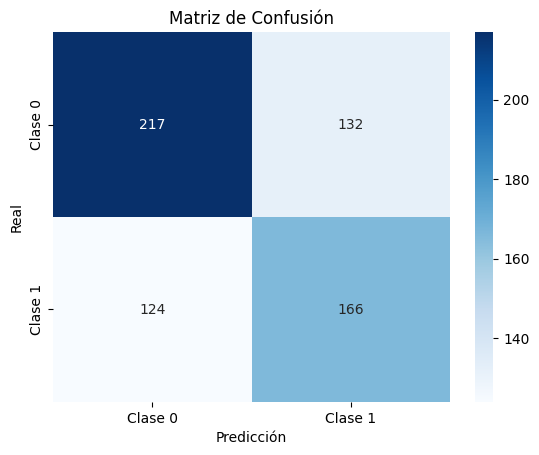

In [47]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_val_pred)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

Si observamos la matriz de confusión podemos ver que la precisión en ambas clases se ha equilibrado, mejorando notablemente las predicciones en los combates que gana el no favorito.

In [48]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_grid.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(feature_importance)

             Feature  Importance
62           Racha_A    0.020823
21      STR_HEAD_B_x    0.017630
64          Puntos_A    0.017458
54     Derrotas_KO_A    0.017181
5          TD_PORC_B    0.016708
..               ...         ...
67          Peleas_B    0.010523
56    Derrotas_Sub_A    0.010482
9              REV_B    0.010436
34  STR_DISTANCE_A_y    0.010184
51   Victorias_Sub_B    0.009536

[74 rows x 2 columns]


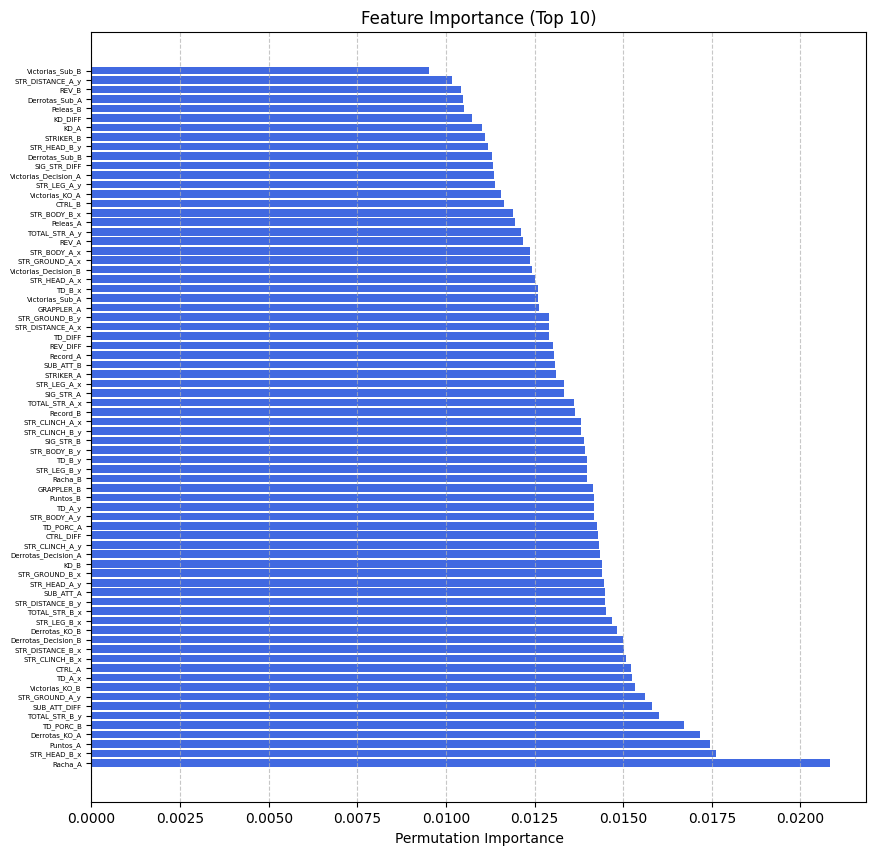

In [49]:
plt.figure(figsize=(10, 10))
plt.barh(feature_importance["Feature"], feature_importance["Importance"], color="royalblue")
plt.xlabel("Permutation Importance")
plt.title("Feature Importance (Top 10)")
plt.yticks(fontsize=5)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

Podemos ver que no hay una variable a la cual se le de una gran importancia, estando todas mas o menos equilibrada. Vemos que el modelo considera la Racha del peleador A como la variable más importante.

#### Random Search

In [50]:
def train_xgboost_random(X_train, y_train, X_val, y_val):
    # Calcular pesos de clase para manejar desbalance de datos
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    scale_pos_weight = class_weights[1] / class_weights[0] if len(class_weights) > 1 else 1
    tscv = TimeSeriesSplit(n_splits=5)
    # Definir modelo base
    xgb = XGBClassifier(random_state=42)


    
    param_dist = {
        'n_estimators': np.arange(50, 400, 50),
        'max_depth': np.arange(3, 40, 2),
        'learning_rate': np.linspace(0.005, 0.2, 15),
        'subsample': np.linspace(0.5, 1.0, 6),
        'colsample_bytree': np.linspace(0.5, 1.0, 6),
        'gamma': np.linspace(0, 0.5, 6),
        'min_child_weight': np.arange(1, 70, 2),
        'scale_pos_weight': [1, scale_pos_weight],
        'reg_alpha': [0, 0.1, 0.5, 1], #Parámetro regularización
        'tree_method': ['auto', 'exact', 'approx', 'hist'], #Método construcción árbol
        'grow_policy': ['depthwise', 'lossguide'] #Política crecimiento árbol
    }

    # Definir la métrica de optimización como el F1-score macro
    f1_scorer = make_scorer(f1_score, average='macro')
    # Búsqueda con validación cruzada
    random_search = RandomizedSearchCV(
        estimator=xgb,
        param_distributions=param_dist,
        scoring=f1_scorer,
        n_iter=50,
        cv=tscv,
        n_jobs=-1,
        verbose=2,
        random_state=42
    )

    # Entrenar el modelo
    random_search.fit(X_train, y_train)

    # Imprimir mejores parámetros
    print("Mejores parámetros:", random_search.best_params_)

    # Evaluar el mejor modelo en el conjunto de validación
    y_pred = random_search.best_estimator_.predict(X_val)
    print("Reporte de clasificación:")
    print(classification_report(y_val, y_pred))


    return random_search

In [51]:
print("-- Entrenamiento usando ajuste de hiperparámetros con RandomizedSeachCV --")
resultados_random = train_xgboost_random(X_train,y_train,X_test,y_test)
best_random = resultados_random.best_estimator_
results_cv = resultados_random.cv_results_

-- Entrenamiento usando ajuste de hiperparámetros con RandomizedSeachCV --
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Mejores parámetros: {'tree_method': 'approx', 'subsample': np.float64(0.5), 'scale_pos_weight': np.float64(1.2905829596412555), 'reg_alpha': 0.1, 'n_estimators': np.int64(200), 'min_child_weight': np.int64(21), 'max_depth': np.int64(7), 'learning_rate': np.float64(0.13035714285714287), 'grow_policy': 'depthwise', 'gamma': np.float64(0.30000000000000004), 'colsample_bytree': np.float64(0.6)}
Reporte de clasificación:
              precision    recall  f1-score   support

       False       0.59      0.57      0.58       349
        True       0.50      0.52      0.51       290

    accuracy                           0.55       639
   macro avg       0.55      0.55      0.55       639
weighted avg       0.55      0.55      0.55       639



In [52]:
print("-- Métricas del modelo con hiperparámetros ajustados --")
y_val_pred = best_random.predict(X_test)
y_val_prob = best_random.predict_proba(X_test)[:,1]
print("Accuracy:", accuracy_score(y_test, y_val_pred))
f1_val = f1_score(y_test, y_val_pred)
roc_auc_val = roc_auc_score(y_test, y_val_prob)
precision_val = precision_score(y_test, y_val_pred)
recall_val = recall_score(y_test, y_val_pred)
log_loss_val = log_loss(y_test,y_val_prob)
print(f"F1-Score: {f1_val:.4f}")
print(f"AUC-ROC: {roc_auc_val:.4f}")
print(f"Precisión: {precision_val:.4f}")
print(f"Sensibilidad: {recall_val:.4f}")
print(f"Log-loss: {log_loss_val}")
print(confusion_matrix(y_test, y_val_pred))

-- Métricas del modelo con hiperparámetros ajustados --
Accuracy: 0.5477308294209703
F1-Score: 0.5110
AUC-ROC: 0.5836
Precisión: 0.5017
Sensibilidad: 0.5207
Log-loss: 0.740057437912212
[[199 150]
 [139 151]]


Obtenemos un resultado notablemente peor que en la búsqueda con rejilla. El modelo es ligeramente mejor que el modelo baseline. También debemos tener en cuenta que el coste computacional ha sido notablemente menor que en la búsqueda en rejilla.

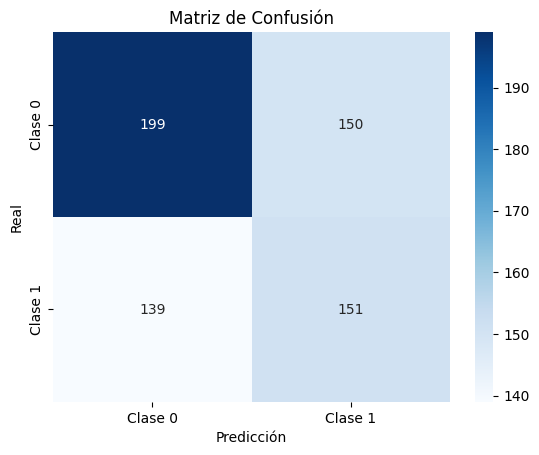

In [54]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_val_pred)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

Podemos ver en la matriz de confusión que, aunque el accuracy no sea mucho mejor que en el modelo base, la detección de casos en las que pierde el luchador favorito ha mejorado respecto el modelo baseline.

In [55]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_random.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(feature_importance)

           Feature  Importance
62         Racha_A    0.019418
54   Derrotas_KO_A    0.016581
57  Derrotas_Sub_B    0.016316
27    STR_BODY_B_y    0.015978
45       STRIKER_B    0.015973
..             ...         ...
69    SIG_STR_DIFF    0.011630
61        Record_B    0.011353
20    STR_HEAD_A_x    0.011066
68         KD_DIFF    0.011052
56  Derrotas_Sub_A    0.010156

[74 rows x 2 columns]


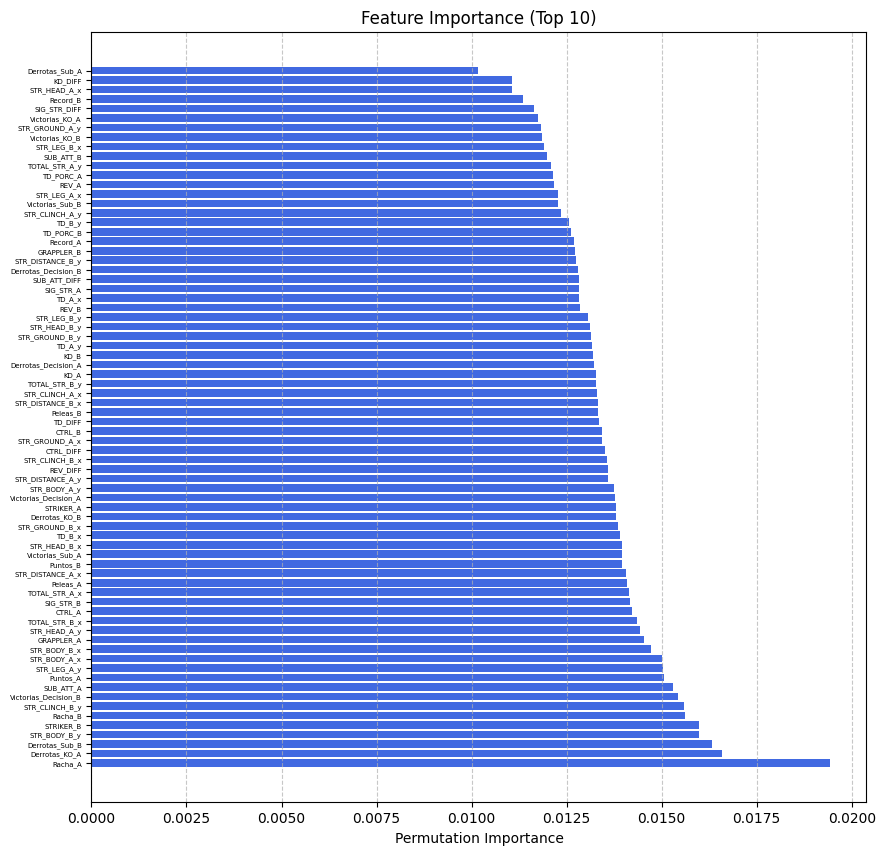

In [56]:
plt.figure(figsize=(10, 10))
plt.barh(feature_importance["Feature"], feature_importance["Importance"], color="royalblue")
plt.xlabel("Permutation Importance")
plt.title("Feature Importance (Top 10)")
plt.yticks(fontsize=5)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

Vemos que las variables a las que se le da importancia son similares a la de la búsqueda en rejilla intercambiando el orden de algunas. Se mantiene la similitud entre importancia entre las variables.

#### Optuna

Dado que Optuna emplea métodos de optimización estocásticos, probamos diferentes semillas iniciales para reducir el riesgo de converger a mínimos locales.

In [28]:
import random
random.seed(42)
np.random.seed(42)

In [35]:
import numpy as np
import optuna
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

def objective(trial, X_train, y_train):
    # Calcular pesos de clase para manejar desbalance de datos
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    scale_pos_weight = class_weights[1] / class_weights[0] if len(class_weights) > 1 else 1

    params = {
    'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
    'max_depth': trial.suggest_int('max_depth', 3, 49, step=2),  # Ajustado de 40 a 39
    'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2, log=True),
    'subsample': trial.suggest_float('subsample', 0.6, 1.0),
    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
    'gamma': trial.suggest_float('gamma', 0, 1.0),
    'min_child_weight': trial.suggest_int('min_child_weight', 1, 69, step=2),  
    'scale_pos_weight': trial.suggest_categorical('scale_pos_weight', [1, scale_pos_weight]),
    'reg_alpha': trial.suggest_categorical('reg_alpha', [0, 0.1, 0.5, 1]),
    'tree_method': trial.suggest_categorical('tree_method', ['auto', 'exact', 'approx', 'hist']),
    'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
    'random_state': 42
}

    # Validación cruzada con series temporales
    tscv = TimeSeriesSplit(n_splits=5)
    model = XGBClassifier(**params)
    optuna.logging.set_verbosity(optuna.logging.INFO)
    scores = cross_val_score(model, X_train, y_train, cv=tscv, scoring='f1_macro', n_jobs=-1)
    return np.mean(scores)  # Retornamos el F1-score promedio

In [36]:
print("-- Entrenamiento usando ajuste de hiperparámetros con Optuna --")
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=200)

best_params = study.best_params
best_model = XGBClassifier(**best_params)
best_model.fit(X_train, y_train)

print("Mejores parámetros:", best_params)

[I 2025-03-25 10:17:04,315] A new study created in memory with name: no-name-0f9faec8-ec98-4616-b6e6-f2905f9ed662


-- Entrenamiento usando ajuste de hiperparámetros con Optuna --


[I 2025-03-25 10:17:06,072] Trial 0 finished with value: 0.47498247240113856 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.0838390275940266, 'subsample': 0.7706586926757916, 'colsample_bytree': 0.8100223528730546, 'gamma': 0.004977330384147383, 'min_child_weight': 55, 'scale_pos_weight': 1, 'reg_alpha': 1, 'tree_method': 'exact', 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.47498247240113856.
[I 2025-03-25 10:17:09,412] Trial 1 finished with value: 0.49586715485073113 and parameters: {'n_estimators': 250, 'max_depth': 41, 'learning_rate': 0.002897168199610996, 'subsample': 0.8629385568426451, 'colsample_bytree': 0.5864366088314528, 'gamma': 0.9177174364704654, 'min_child_weight': 61, 'scale_pos_weight': np.float64(1.2905829596412555), 'reg_alpha': 1, 'tree_method': 'approx', 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.49586715485073113.
[I 2025-03-25 10:17:11,382] Trial 2 finished with value: 0.5000847167080003 and parameters: {'n

Mejores parámetros: {'n_estimators': 350, 'max_depth': 37, 'learning_rate': 0.024692253002880315, 'subsample': 0.719935922746133, 'colsample_bytree': 0.5848126858685145, 'gamma': 0.6643425907705918, 'min_child_weight': 39, 'scale_pos_weight': np.float64(1.2905829596412555), 'reg_alpha': 0, 'tree_method': 'exact', 'grow_policy': 'depthwise'}


In [37]:
y_val_pred = best_model.predict(X_test)
y_val_prob = best_model.predict_proba(X_test)[:,1]

print("-- Métricas del modelo con hiperparámetros ajustados --")
print("Accuracy:", accuracy_score(y_test, y_val_pred))
print(f"F1-Score: {f1_score(y_test, y_val_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_val_prob):.4f}")
print(f"Precisión: {precision_score(y_test, y_val_pred):.4f}")
print(f"Sensibilidad: {recall_score(y_test, y_val_pred):.4f}")
print(f"Log-loss: {log_loss(y_test, y_val_prob):.4f}")

-- Métricas del modelo con hiperparámetros ajustados --
Accuracy: 0.564945226917058
F1-Score: 0.5304
AUC-ROC: 0.6028
Precisión: 0.5199
Sensibilidad: 0.5414
Log-loss: 0.6826


Mejor modelo conseguido con Optuna

In [57]:
params = {
    'n_estimators': 350,
    'max_depth': 37,
    'learning_rate': 0.014525356301837976,
    'subsample': 0.6223758299538741,
    'colsample_bytree': 0.5603666759669468,
    'gamma': 0.4820740200787993,
    'min_child_weight': 31,
    'scale_pos_weight': np.float64(1.2905829596412555),
    'reg_alpha': 0.1,
    'tree_method': 'exact',
    'grow_policy': 'lossguide',
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}

# Crear y entrenar modelo
best_model = XGBClassifier(**params)
best_model.fit(X_train, y_train)

# Evaluación
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print(f"F1-score: {f1_score(y_test,y_pred)}")

Accuracy: 0.5837
F1-score: 0.5581395348837209


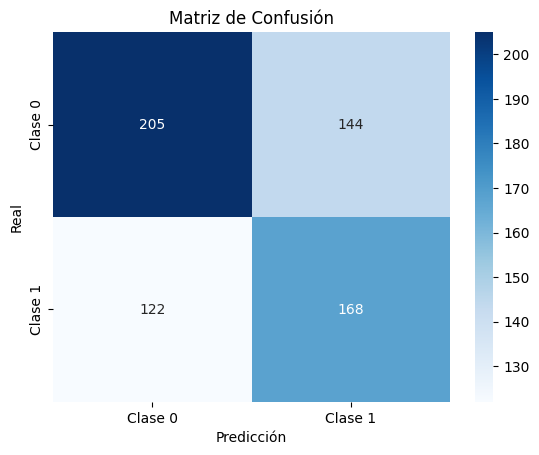

In [58]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

No conseguimos mejorar el modelo encontrado con GridSearch. Esto puede deberse a que el modelo obtenido con esta estrategia ya era muy bueno (logrando una mejora notable respecto al modelo base) o a que el espacio de búsqueda definido en Optuna no fue el más adecuado.

In [61]:
if mlflow.active_run():
    mlflow.end_run()

# Iniciar un nuevo experimento
with mlflow.start_run(run_name="uso de Optuna para ajustar hiperparámetros"):

    # Guardar modelo en MLflow
    mlflow.log_param("mejores_parametros", best_params)
    mlflow.log_metric("accuracy", accuracy_score(y_test, y_val_pred))
    mlflow.log_metric("f1_macro", f1_score(y_test, y_val_pred))

    print("Modelo guardado en MLflow")

Modelo guardado en MLflow


In [42]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(feature_importance)

                 Feature  Importance
62               Racha_A    0.020478
21          STR_HEAD_B_x    0.019050
64              Puntos_A    0.016132
8                  REV_A    0.015911
71          SUB_ATT_DIFF    0.015626
..                   ...         ...
6              SUB_ATT_A    0.011594
55         Derrotas_KO_B    0.011582
41        STR_GROUND_B_x    0.011455
60              Record_A    0.011311
52  Victorias_Decision_A    0.010938

[74 rows x 2 columns]


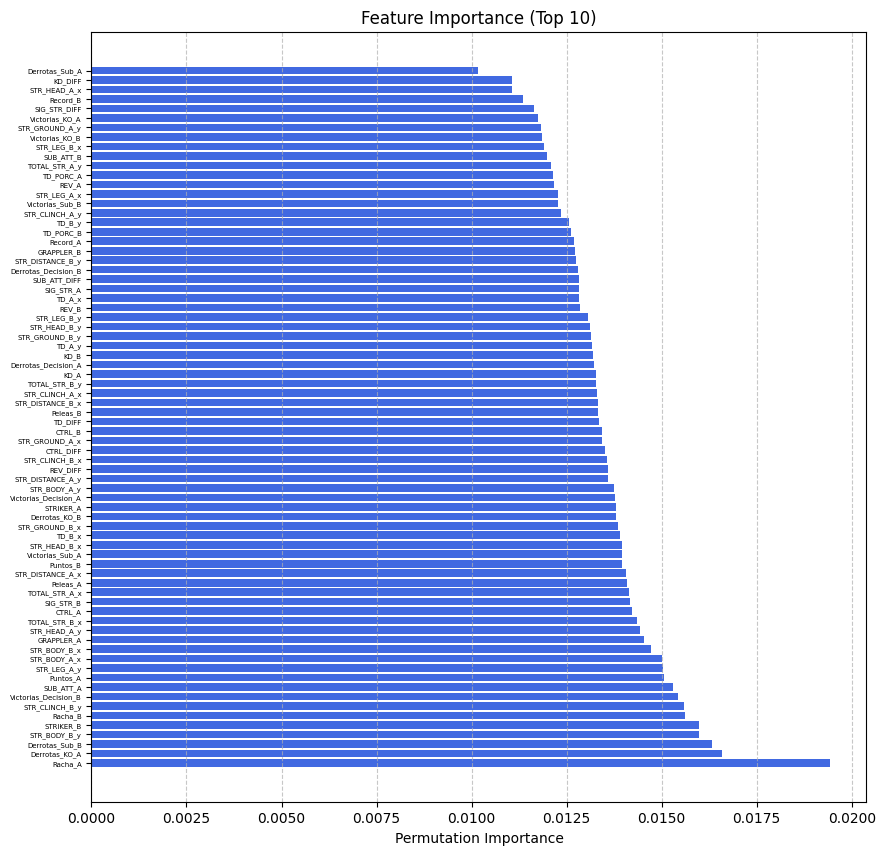

In [62]:
plt.figure(figsize=(10, 10))
plt.barh(feature_importance["Feature"], feature_importance["Importance"], color="royalblue")
plt.xlabel("Permutation Importance")
plt.title("Feature Importance (Top 10)")
plt.yticks(fontsize=5)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

#### CONCLUSIONES

Tras comparar las estrategias, observamos que GridSearchCV encontró el mejor ajuste de hiperparámetros. Optuna en este caso no consiguió mejorar el modelo encontrado por GridSearchCV.  

Por otro lado, RandomizedSearchCV, aunque no explora todas las combinaciones, logra un resultado competitivo con un tiempo de ejecución significativamente menor. Esto nos sugiere que puede ser una alternativa eficiente dependiendo de las restricciones computacionales y los objetivos del modelo.

Hemos conseguido mejorar el resultado del modelo baseline lo cual nos indica que los ajustes de hiperparámetros han sido correctos. 
No hemos conseguido obtener buenos resultados en temas de accuracy, consideramos que esto se debe a que al realizar las medias ponderadas muchos datos no son tan representativos y no tienen gran relación con el ganador de un futuro combate. A esta conclusión llegamos viendo que la importancia de las variables es bastante baja y muchas variables pierden mucha importancia respecto al modelo con datos reales de peleas.